In [7]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import optuna
import random
import itertools
from itertools import permutations
torch.set_printoptions(edgeitems=2, linewidth=75)

In [8]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.tensor([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [9]:
# 各CSVファイルの読み込み
csv_files1 = ['xy(1) copy.csv', 'xy(2) copy.csv', 'xy(3) copy.csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['xy1 copy.csv', 'xy2 copy.csv', 'xy3 copy.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [10]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [11]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [12]:
# 最適化のためのobjective関数
def objective(trial):
    # パラメータをsuggestする
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(trial.suggest_float('k5', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k6 = torch.tensor(trial.suggest_float('k6', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

    y_p1 = outputs[0]['shift1'][0]
    y_p2 = outputs[1]['shift1'][1]
    y_p3 = outputs[2]['shift1'][2]
    y_p4 = outputs[3]['shift2'][0]
    y_p5 = outputs[4]['shift2'][1]
    y_p6 = outputs[5]['shift2'][2]

    # ロス計算
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)
    
    return loss.item()

# 最適なパラメータを見つけるためのループ
best_epoch0_loss = float('inf')
best_params = None

for _ in range(10):
    # Optunaで最適化
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # epoch0のLossが最小のパラメータを保持
    if study.best_value < best_epoch0_loss:
        best_epoch0_loss = study.best_value
        best_params = study.best_params

# 最適なパラメータでのトレーニング
if best_params is not None:
    k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
    k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
    k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
    k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
    k5 = torch.nn.Parameter(torch.tensor(best_params['k5']))
    k6 = torch.nn.Parameter(torch.tensor(best_params['k6']))
    t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
    p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
    t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
    p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

    optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-2)

    prev_loss = float('inf')

    for epoch in range(10000):
        optimizer.zero_grad()

        outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

        y_p1 = outputs[0]['shift1'][0]
        y_p2 = outputs[1]['shift1'][1]
        y_p3 = outputs[2]['shift1'][2]
        y_p4 = outputs[3]['shift2'][0]
        y_p5 = outputs[4]['shift2'][1]
        y_p6 = outputs[5]['shift2'][2]

        loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

        if epoch == 0:
            epoch0_loss = loss.item()
            if epoch0_loss >= 35:
                print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                break

        if loss.item() > prev_loss:
            print(f"Loss increased at epoch {epoch}. Stopping training.")
            break

        prev_loss = loss.item()
        loss.backward()
        optimizer.step()

        # パラメータのクランプ
        with torch.no_grad():
            # Clamp the first 6 parameters to be within [-10, 10]
            for param in [k1, k2, k3, k4, k5, k6]:
                param.data = torch.clamp(param.data, -10.0, 10.0)
        
            # Clamp the remaining 4 parameters to be within [0, 90]
            for param in [t1, p1, t2, p2]:
                param.data = torch.clamp(param.data, 0.0, 90.0)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

[I 2024-09-25 20:52:02,201] A new study created in memory with name: no-name-f272a2a1-d625-4b5a-a281-40b5d8333787
[I 2024-09-25 20:52:02,230] Trial 0 finished with value: 304.097412109375 and parameters: {'k1': 7.320099775799957, 'k2': -2.148097608758648, 'k3': -9.705165585499365, 'k4': 5.388849731835631, 'k5': -6.187655884189265, 'k6': 0.5459558347413456, 't1': 5.25020918954181, 'p1': 83.03760300334766, 't2': 32.78467790008131, 'p2': 87.61547571442507}. Best is trial 0 with value: 304.097412109375.
[I 2024-09-25 20:52:02,253] Trial 1 finished with value: 118.14517974853516 and parameters: {'k1': -3.1439509937151255, 'k2': -4.378668711624489, 'k3': -1.2388512360946375, 'k4': -7.885875810143206, 'k5': -5.128932864204865, 'k6': 1.5331823366946757, 't1': 6.897032312761027, 'p1': 50.51025888914429, 't2': 9.455955827109513, 'p2': 37.84038470733654}. Best is trial 1 with value: 118.14517974853516.
[I 2024-09-25 20:52:02,278] Trial 2 finished with value: 129.5294952392578 and parameters: {'k1

Epoch 0, Loss: 23.272415161132812
Epoch 100, Loss: 11.154276847839355
Epoch 200, Loss: 5.870594024658203
Epoch 300, Loss: 3.6798908710479736
Epoch 400, Loss: 2.728466510772705
Epoch 500, Loss: 2.167041063308716
Epoch 600, Loss: 1.9043514728546143
Epoch 700, Loss: 1.668170690536499
Epoch 800, Loss: 1.4546093940734863
Epoch 900, Loss: 1.2617658376693726
Epoch 1000, Loss: 1.0882785320281982
Epoch 1100, Loss: 0.9329739212989807
Epoch 1200, Loss: 0.7947357296943665
Epoch 1300, Loss: 0.6724448204040527
Epoch 1400, Loss: 0.5649728178977966
Epoch 1500, Loss: 0.47117358446121216
Epoch 1600, Loss: 0.3898980915546417
Epoch 1700, Loss: 0.32000645995140076
Epoch 1800, Loss: 0.26038065552711487
Epoch 1900, Loss: 0.2099355012178421
Epoch 2000, Loss: 0.16763268411159515
Epoch 2100, Loss: 0.13248683512210846
Epoch 2200, Loss: 0.10357514023780823
Epoch 2300, Loss: 0.08004053682088852
Epoch 2400, Loss: 0.06109730899333954
Epoch 2500, Loss: 0.04603106528520584
Epoch 2600, Loss: 0.03420102596282959
Epoch 2

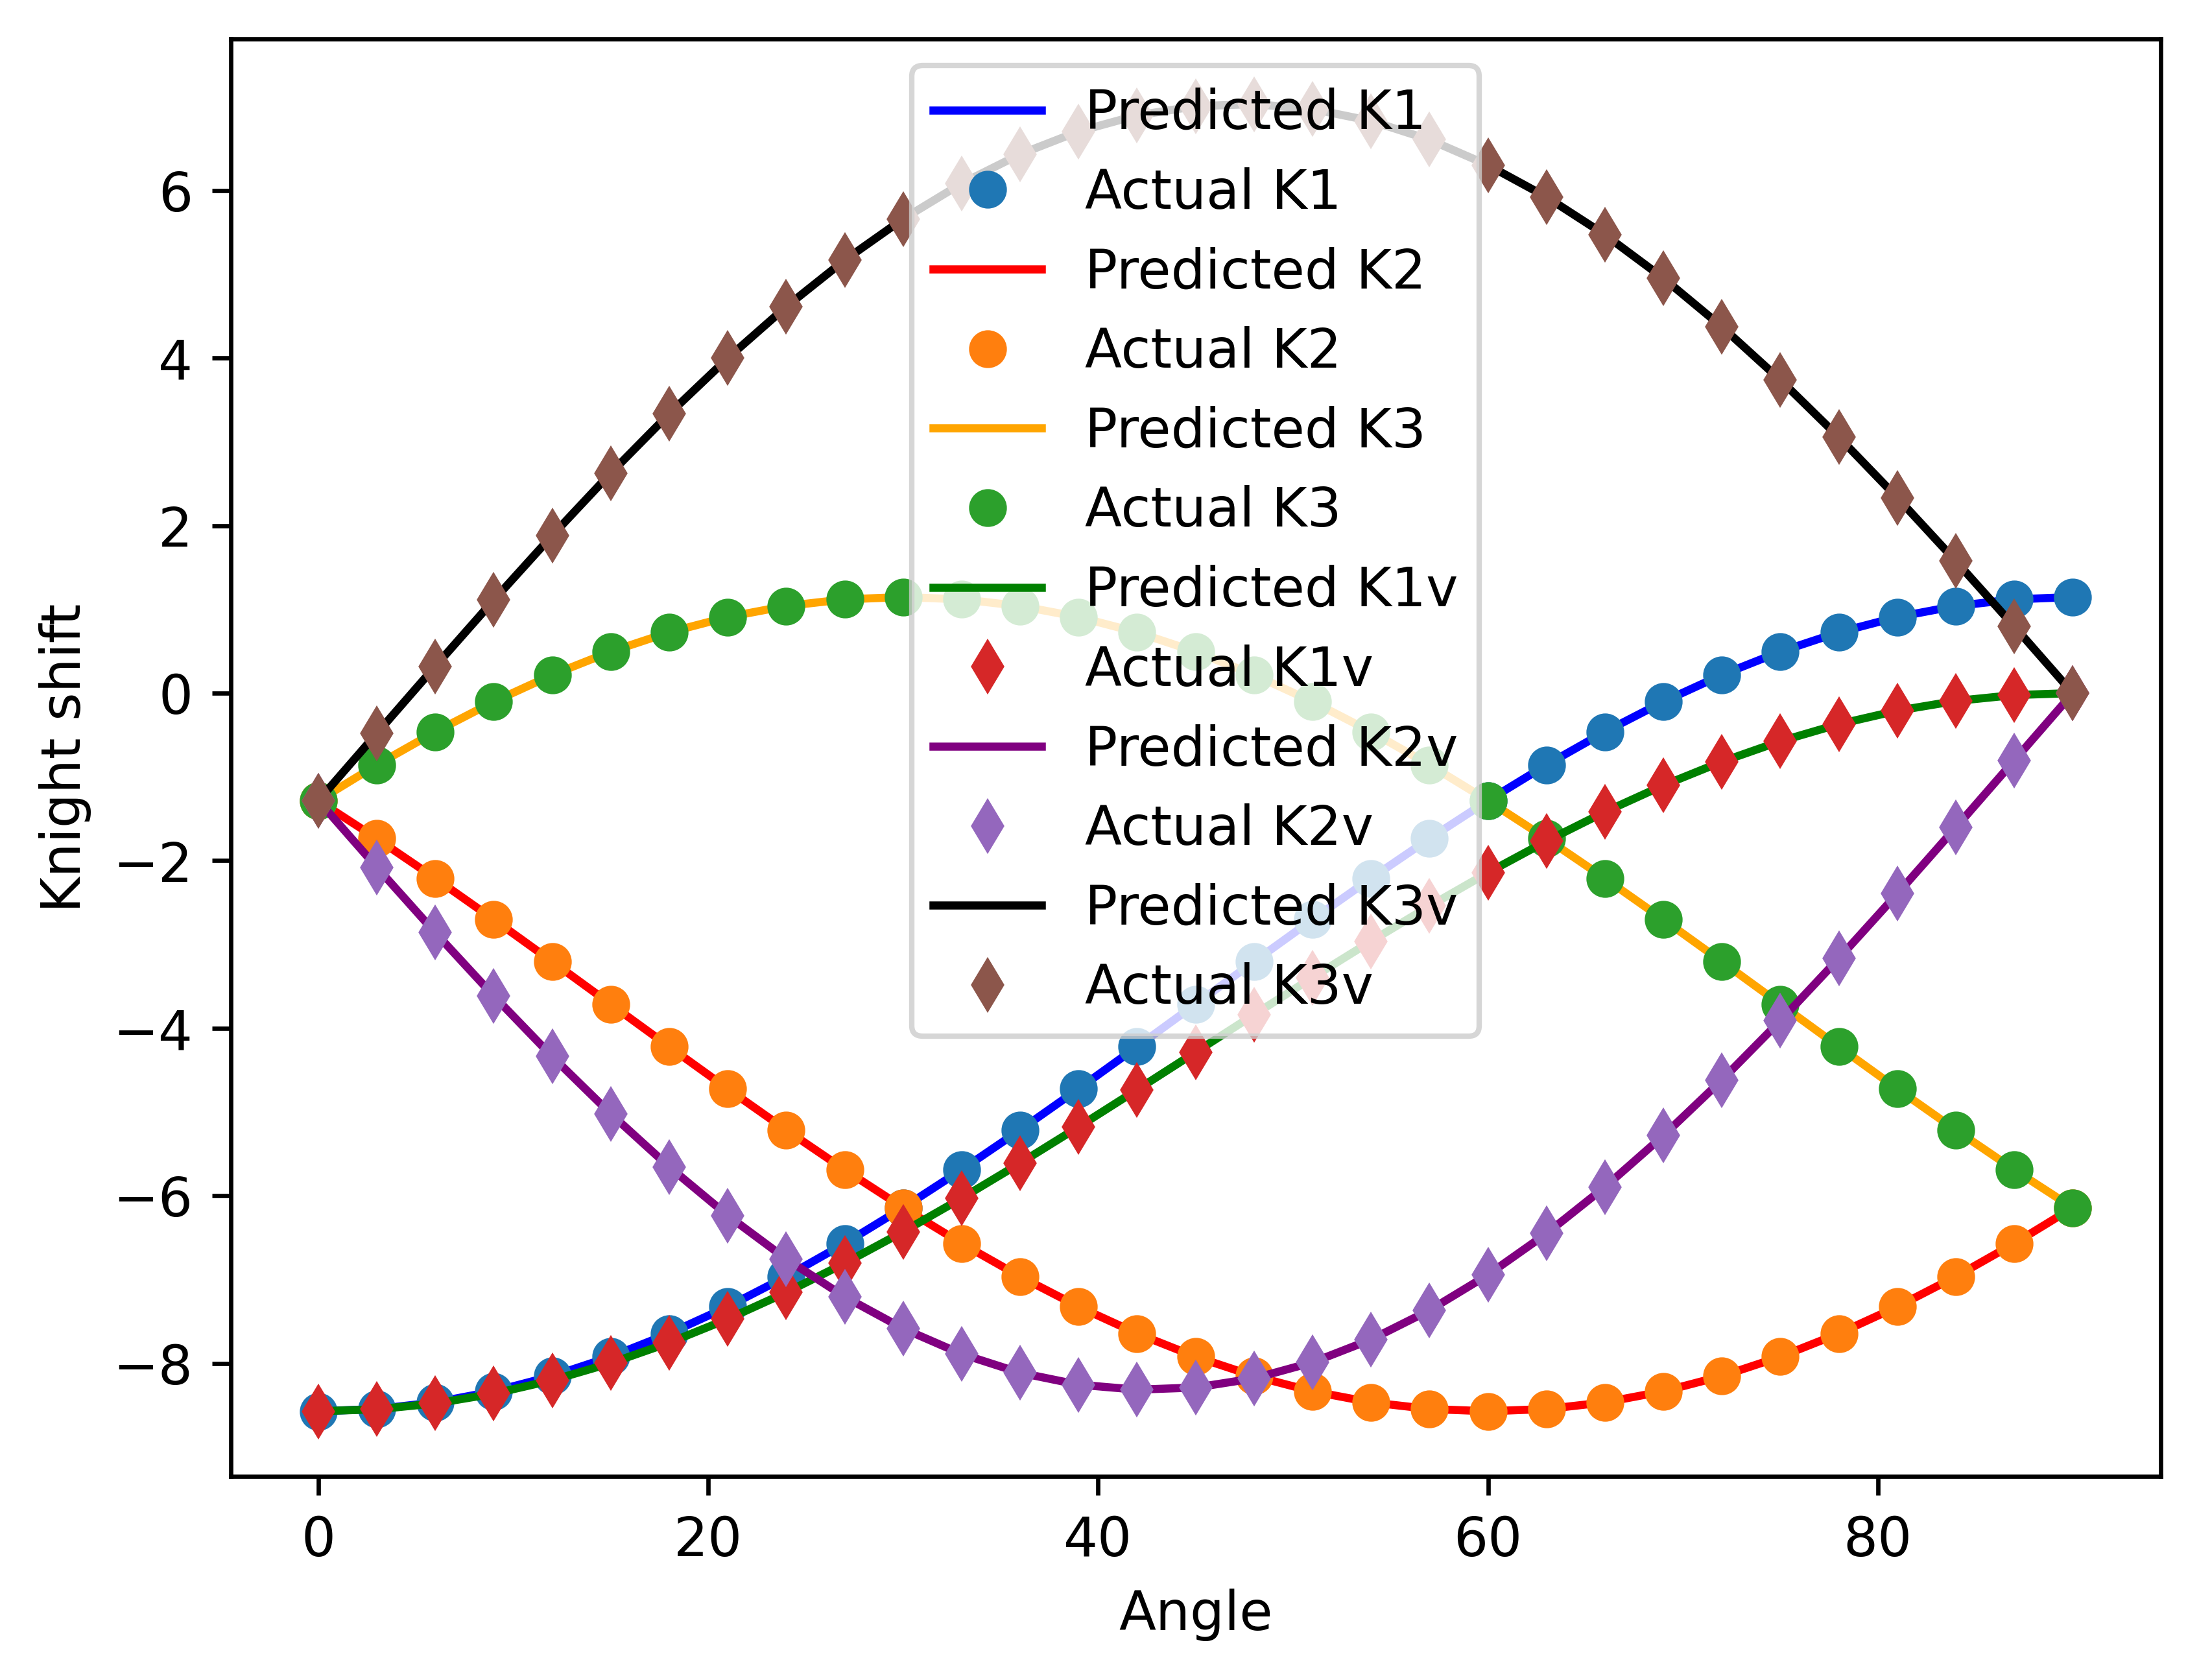

[tensor(-8.5720), tensor(1.1460), tensor(-2.5032e-07), tensor(8.8300), tensor(2.6198e-05), tensor(-4.7797e-06), tensor(0.0003), tensor(22.6732), tensor(90.), tensor(0.)]


In [13]:
# 最適化後のパラメータを取得し、Tensorに変換
params = [torch.tensor(val) for val in [k1.item(), k2.item(), k3.item(), k4.item(), k5.item(), k6.item(), t1.item(), p1.item(), t2.item(), p2.item()]]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'o', label="Actual K2")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'o', label="Actual K3")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'd', label="Actual K1v")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'd', label="Actual K2v")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'd', label="Actual K3v")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()
print(params)